### Trying out R6B with feature dimensionality reduced

Algorithm performance on R6B is different to that of R6A. E-greedy and UCB1 perform better than contextual algorithms. My hypothesis is that it might be due to feature vectors being raw and high dimensional. I want to check if reducing the feature vector dimension will change the relative performance of contextual and context-free algorithms.

Plan:

#### 1st part:
- Create X - matrix of features from events of shape (3033740, 136)
- Try truncated svd on this matrix
- compute the square average risk and find appropriate k - dimension 
- try running ucb and linucb on it

#### 2nd part, centroid method:
- Cluster all the users into k clusters using K-means
- For each user calculate the Soft membership in the k clusters computed with a Gaussian kernel and then normalized

In [1]:
import os
os.chdir('../..')
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD

import algorithms
import evaluation
import dataset
from plotting.average_ctr import get_average_ctr_plot

In [62]:
%%time
import gc

with open("dataset/r6b/subsample/data_10_11.pickle", "rb") as f:
    gc.disable()
    data = pickle.load(f)
    gc.enable()

CPU times: user 5.95 s, sys: 3.4 s, total: 9.35 s
Wall time: 37 s


In [63]:
data

Dataset(n_arms=79,n_events=3033740)

In [64]:
X = np.stack(
 [
     ev.user_features for ev in data.events
 ]
)


In [20]:
svd = TruncatedSVD(n_components=30, random_state=42)
X_reduced = svd.fit_transform(X)

In [21]:
X_reduced.shape

(1000, 30)

In [22]:
X_undo = svd.inverse_transform(X_reduced)

In [38]:
def mean_reconstruction_error(original, reconstructed):
    assert original.shape == reconstructed.shape
    return ((original - reconstructed)**2).sum(axis=1).mean()
    

In [39]:
mean_recostruction_error(X, X_undo)

1.0903405126404406

#### Run algorithms with reduced dimension

In [89]:
DIMENSION = 2

svd = TruncatedSVD(n_components=DIMENSION, random_state=42)
X_reduced = svd.fit_transform(X)

In [90]:
for event, x in zip(data.events,X_reduced):
    event.user_features = x

In [91]:
data.events[0]

Event(timestamp=1318204491, displayed_pool_index=16, user_click=0, user_features=array([2.80092935, 0.49373705]), pool_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [92]:
NUM_OF_TRIALS = 40000

In [93]:
egreedy = algorithms.EpsilonGreedy(epsilon=0.1, n_arms=data.n_arms)
ctr_egreedy = evaluation.evaluate(egreedy, data, stop_after=NUM_OF_TRIALS)

E-greedy(epsilon=0.1) with ZeroCosts
Average reward: 0.0591
Execution time: 9.4s


In [94]:
ucb_alg = algorithms.UCB1(
        n_arms=data.n_arms,
        alpha=0.01,
    )
ctr_ucb = evaluation.evaluate(ucb_alg, data, stop_after=NUM_OF_TRIALS)

UCB1 (α=0.01) with ZeroCosts
Average reward: 0.0622
Execution time: 16.2s


In [95]:
linucb = algorithms.LinUCB(
    context_dimension=len(data.events[0].user_features),
    n_arms=data.n_arms,
    alpha=0.03,
)
ctr_linucb = evaluation.evaluate(linucb, data, stop_after=NUM_OF_TRIALS)

LinUCB (alpha=0.03) with ZeroCosts
Average reward: 0.0527
Execution time: 36.8s


In [ ]:
0.0542

In [96]:
def plot_ctrs(ctr_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(16, 8));
    
    N = 40
    
    max_vline=0
    
    for label, ctr in ctr_dict.items():
        ax.plot(ctr[N:], label=label)
        max_vline=max(max_vline, max(ctr[N:]))
    ax.set_xlabel('Trial')
    ax.set_ylabel('CTR')
    ax.set_title('Evaluation without costs')
    
    ax.vlines(change_points, 0, max_vline, label='change points', color='pink')

    plt.legend();
    plt.show();

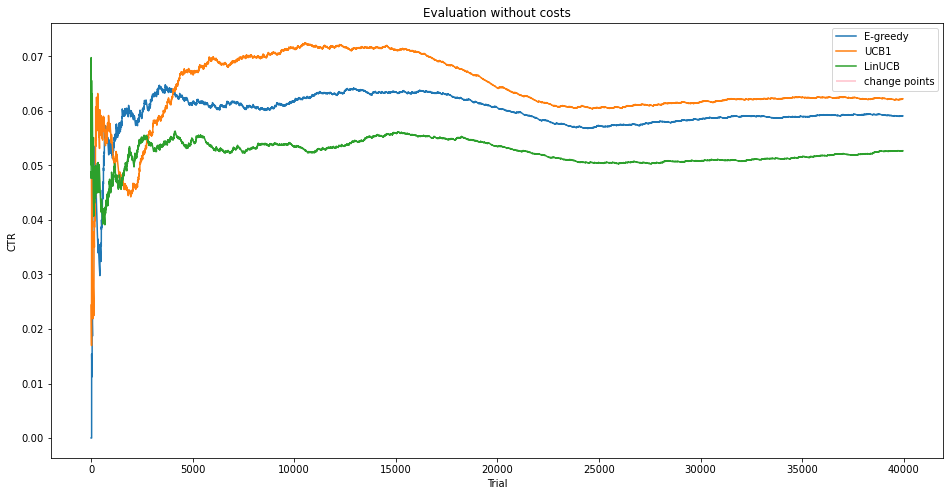

In [97]:
plot_ctrs({
    'E-greedy': ctr_egreedy,
    'UCB1': ctr_ucb,
    'LinUCB': ctr_linucb,
},
)


### Part 2 - Clustering and Gaussian distances to centroids